## INITIAL VERSION

### INSTALLING DEPENDENCIES

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install sklearn
%pip install imblearn

### DATA READING

In [1]:
with open('data.json') as f:
    first_line = f.readline()
    print(first_line.strip())

FileNotFoundError: [Errno 2] No such file or directory: 'data.json'

In [ ]:
# only read COUNT from 10 million of JSON objects (approximately 4 minutes for 1 million)

import pandas as pd
import json

# adjust the count to read a different number of lines
COUNT = 1000000

data = []
with open('data.json', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= COUNT:
            break
        data.append(json.loads(line))

df = pd.DataFrame(data)

df.head()

### FEATURE SELECTION

In [ ]:
df.info()

In [ ]:
# inspect different values

targets = ['hirable', 'type', 'updated_at']

for label in targets:
    print(f"Unique values for {label}:")
    unique_values = df[label].unique()
    print(unique_values)

In [ ]:
df.tail(9)

we can see that user 33200309 is following user 2672982. let's try to prove it if it exist in our 10% fraction of the whole dataset.

In [ ]:
# check if the user exists in the dataframe
user_id = 2672982
user_exists = df[df['id'] == user_id].shape[0] > 0
if user_exists:
    user_data = df[df['id'] == user_id].iloc[0]
    print(f"Follower list for user {user_id}:")
    print(user_data['follower_list'])
else:
    print(f"User with id {user_id} does not exist in the dataframe.")

In [ ]:
df.info()

In [ ]:
# drop the columns that are not needed

targets = ['updated_at', 'id', 'created_at', 'follower_list', 'following_list', 'commit_list', 'name', 'email', 'repo_list']

df.drop(columns=targets, inplace=True)

df.info()

### ENCODING

In [ ]:
# encode company to 0 if null, otherwise 1

df['company'] = df['company'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['company'].value_counts()

In [ ]:
# encode hirable to 0 if null, otherwise 1

df['hirable'] = df['hirable'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['hirable'].value_counts()

In [ ]:
# encode location to 0 if null, otherwise 1

df['location'] = df['location'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['location'].value_counts()

In [ ]:
# encode bio to 0 if null, otherwise 1

df['bio'] = df['bio'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['bio'].value_counts()

In [ ]:
# set commits to 0 if null

df['commits'] = df['commits'].apply(lambda x: 0 if pd.isnull(x) else x)

df.info()

In [ ]:
# encode type Bot to 0, User to 1, Organization to 2

df['type'] = df['type'].apply(lambda x: 0 if x == 'Bot' else (1 if x == 'User' else 2))
df['type'].value_counts()

In [ ]:
# print the unique values for blog

df['blog'].unique()

In [ ]:
# encode blog to 0 if empty, otherwise 1

df['blog'] = df['blog'].apply(lambda x: 0 if pd.isnull(x) or x == '' else 1)
df['blog'].value_counts()

In [ ]:
df.info()

In [ ]:
# show the correlation of all columns towards is_suspicious

df_tmp = df.drop(columns=['login'])

df_tmp.corr()['is_suspicious'].sort_values(ascending=False)

### DATA ANALYSIS

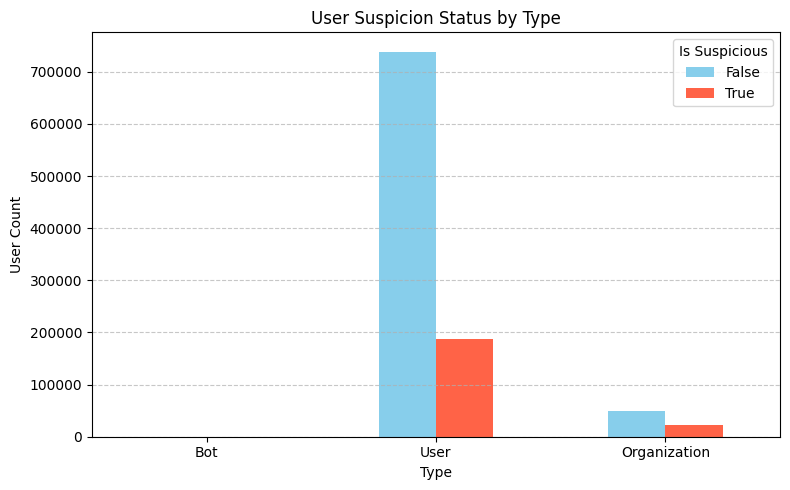

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapping from encoded type to label
type_labels = {0: 'Bot', 1: 'User', 2: 'Organization'}

# Group by 'type' and 'is_suspicious', then count
grouped = df.groupby(['type', 'is_suspicious']).size().unstack(fill_value=0)
grouped = grouped.reindex([0, 1, 2], fill_value=0)

# Plot
ax = grouped.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'tomato'])
plt.title('User Suspicion Status by Type')
plt.xlabel('Type')
plt.ylabel('User Count')
plt.xticks(ticks=range(len(type_labels)), labels=[type_labels[t] for t in grouped.index], rotation=0)
plt.legend(title='Is Suspicious', labels=['False', 'True'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
# Define expected types
expected_types = [0, 1, 2]

# Group and count
grouped = df.groupby(['type', 'is_suspicious']).size().unstack(fill_value=0)

# Ensure all types are present
grouped = grouped.reindex(expected_types, fill_value=0)

# Print the result
print("User counts by type and suspicion status:")
print(grouped)

# Calculate total users per type
grouped['total'] = grouped[False] + grouped[True]

# Calculate percentage of suspicious users
grouped['suspicious_percent'] = (grouped[True] / grouped['total']) * 100

# Round for readability
grouped['suspicious_percent'] = grouped['suspicious_percent'].round(2)

# Display the result
print("\nSuspicious user percentage by type:")
print(grouped[['suspicious_percent']])

User counts by type and suspicion status:
is_suspicious   False   True 
type                         
0                 155       0
1              738881  188388
2               49157   23419

Suspicious user percentage by type:
is_suspicious  suspicious_percent
type                             
0                            0.00
1                           20.32
2                           32.27


### BUILDING MODEL

In [16]:
import pandas as pd

df = pd.read_csv('data_processed.csv')

In [17]:
# add new column for profile completeness
df['profile_completeness'] = df[['company', 'hirable', 'location', 'bio', 'blog']].sum(axis=1)

# add new column for commit_to_public_repo
df['commit_to_public_repo'] = df['commits'] / (df['public_repos'] + 1)

In [18]:
X = df.drop(columns=['is_suspicious', 'login'])
y = df['is_suspicious']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [19]:
# train an XGBoost model
import xgboost as xgb

model = xgb.XGBClassifier(
	n_estimators=100,
	max_depth=6,
	learning_rate=0.1,
	random_state=42,
	eval_metric='logloss',
)

model.fit(X_train, y_train)

model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
# evaluate the classification report on train

from sklearn.metrics import classification_report

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90    630730
        True       0.89      0.25      0.39    169270

    accuracy                           0.83    800000
   macro avg       0.86      0.62      0.64    800000
weighted avg       0.84      0.83      0.79    800000



In [21]:
# evaluate the classification report on test

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90    157463
        True       0.89      0.24      0.38     42537

    accuracy                           0.83    200000
   macro avg       0.86      0.62      0.64    200000
weighted avg       0.84      0.83      0.79    200000



In [9]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("False Positives:", confusion_matrix(y_test, y_pred)[1][0])
print("False Negatives:", confusion_matrix(y_test, y_pred)[0][1])

Confusion Matrix:
[[156080   1383]
 [ 32101  10436]]
False Positives: 32101
False Negatives: 1383


In [5]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[156065   1398]
 [ 32068  10469]]


this is our first version of our model where we have more FN than FP. in this case, it's better to decrease FN by increasing FP as tradeoff. thus, we tried to adjust our model as below.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.285  # Try adjusting this
y_pred = (y_probs >= threshold).astype(int)

In [ ]:
# evaluate the model's accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

# evaluate the model's precision
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred)
print(f"Model precision: {precision:.2f}")

# evaluate the model's recall
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print(f"Model recall: {recall:.2f}")

In [ ]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

we managed to decrease FN by a little bit and increase FP. even though it decreases the precision, it didn't increase the recall at all. it also decreases our accuracy by a small amount. it is still questionable if this is better than the previous version.

### SAVE THE CHANGES

In [ ]:
# save our pandas dataframe to a CSV file

df.to_csv('data_processed.csv', index=False)

print("Changes saved.")

### TRY FOR COMPANY AS LABEL (NOT IMPORTANT)

In [ ]:
df.info()

In [ ]:
# print the correlation of all columns towards company

df.corr()['company'].sort_values(ascending=False)

In [ ]:
# print the unique values for location

df['location'].unique()

# print count for each location

df['location'].value_counts()

In [ ]:
# build a random forest model_trial to predict the company

X = df.drop(columns=['company', 'is_suspicious'])
y = df['company']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train the model_trial on the SMOTE-resampled data
model_trial = RandomForestClassifier(n_estimators=100, random_state=42)
model_trial.fit(X_train_sm, y_train_sm)

y_pred = model_trial.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Model accuracy: {accuracy:.2f}")
print(f"Model precision: {precision:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# print classification report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

## GET 10 MILLION DATA

In [ ]:
%pip install tqdm

In [1]:
import pandas as pd
import json
from itertools import islice
from tqdm import tqdm

# Set your desired start and end rows
start_row = 10_000_000  # inclusive, 0-based
end_row = 11_000_000    # exclusive

data = []
total = end_row - start_row

with open('data.json', 'r', encoding='utf-8') as f:
	for line in tqdm(islice(f, start_row, end_row), total=total, desc="Reading JSON lines"):
		data.append(json.loads(line))

df = pd.DataFrame(data)

df.head()

Reading JSON lines:  65%|██████▍   | 649574/1000000 [02:46<01:29, 3905.44it/s] 


,hirable,public_repos,is_suspicious,updated_at,id,blog,followers,location,follower_list,type,...,commits,company,following_list,public_gists,name,created_at,email,following,login,repo_list
0,None,0,False,2018-07-18 02:36:41,34761058,,0,None,[],User,...,0.0,None,[],0,None,2017-12-22 04:10:52,None,0,yuzuyusakashita,[]
1,None,4,False,2017-08-05 04:01:35,16456078,,0,None,[],User,...,33.0,None,[],0,None,2015-12-27 22:44:15,None,0,arcanearronax,"[{'fork': False, 'license': None, 'has_wiki': ..."
2,None,2,False,2018-04-13 07:33:57,12585030,,0,None,[],User,...,2.0,None,[],0,None,2015-05-24 14:22:42,None,0,vipview,"[{'fork': False, 'license': None, 'has_wiki': ..."
3,None,0,False,2017-03-03 02:01:27,26154563,,0,None,[],User,...,0.0,None,[],0,None,2017-03-03 02:01:27,None,0,nookp,[]
4,None,2,False,2016-08-11 00:50:26,16039778,,0,None,[],User,...,8.0,None,[],0,None,2015-11-27 00:27:22,None,0,gpmMendes,"[{'fork': False, 'license': None, 'has_wiki': ..."


### DATA PRE-PROCESS

In [2]:
# drop the columns that are not needed

targets = ['updated_at', 'created_at', 'follower_list', 'following_list', 'commit_list', 'name', 'email', 'repo_list']

df.drop(columns=targets, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649574 entries, 0 to 649573
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hirable        14159 non-null   object 
 1   public_repos   649574 non-null  int64  
 2   is_suspicious  649574 non-null  bool   
 3   id             649574 non-null  int64  
 4   blog           649574 non-null  object 
 5   followers      649574 non-null  int64  
 6   location       65491 non-null   object 
 7   type           649574 non-null  object 
 8   bio            43866 non-null   object 
 9   commits        499282 non-null  float64
 10  company        31964 non-null   object 
 11  public_gists   649574 non-null  int64  
 12  following      649574 non-null  int64  
 13  login          649574 non-null  object 
dtypes: bool(1), float64(1), int64(5), object(7)
memory usage: 65.0+ MB


In [3]:
# encode company to 0 if null, otherwise 1

df['company'] = df['company'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['company'].value_counts()

company
0    617610
1     31964
Name: count, dtype: int64

In [4]:
# encode hirable to 0 if null, otherwise 1

df['hirable'] = df['hirable'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['hirable'].value_counts()

hirable
0    635415
1     14159
Name: count, dtype: int64

In [5]:
# encode location to 0 if null, otherwise 1

df['location'] = df['location'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['location'].value_counts()

location
0    584083
1     65491
Name: count, dtype: int64

In [6]:
# encode bio to 0 if null, otherwise 1

df['bio'] = df['bio'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['bio'].value_counts()

bio
0    605708
1     43866
Name: count, dtype: int64

In [7]:
# set commits to 0 if null

df['commits'] = df['commits'].apply(lambda x: 0 if pd.isnull(x) else x)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649574 entries, 0 to 649573
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   hirable        649574 non-null  int64  
 1   public_repos   649574 non-null  int64  
 2   is_suspicious  649574 non-null  bool   
 3   id             649574 non-null  int64  
 4   blog           649574 non-null  object 
 5   followers      649574 non-null  int64  
 6   location       649574 non-null  int64  
 7   type           649574 non-null  object 
 8   bio            649574 non-null  int64  
 9   commits        649574 non-null  float64
 10  company        649574 non-null  int64  
 11  public_gists   649574 non-null  int64  
 12  following      649574 non-null  int64  
 13  login          649574 non-null  object 
dtypes: bool(1), float64(1), int64(9), object(3)
memory usage: 65.0+ MB


In [8]:
# encode type Bot to 0, User to 1, Organization to 2

df['type'] = df['type'].apply(lambda x: 0 if x == 'Bot' else (1 if x == 'User' else 2))
df['type'].value_counts()

type
1    602799
2     46670
0       105
Name: count, dtype: int64

In [9]:
# encode blog to 0 if empty, otherwise 1

df['blog'] = df['blog'].apply(lambda x: 0 if pd.isnull(x) or x == '' else 1)
df['blog'].value_counts()

blog
0    604059
1     45515
Name: count, dtype: int64

### SAVE

In [10]:
# save the data to a CSV file

df.to_csv('data_frag_11.csv', index=False)

## EXPLORING THE POTENTIAL WORKFLOW

### PREPARATION

In [ ]:
%pip install requests
%pip install python-dotenv

In [ ]:
import requests
from dotenv import load_dotenv
import os

In [1]:
# load the csv file
import pandas as pd

df = pd.read_csv('data_processed.csv')
df.head()

,hirable,public_repos,is_suspicious,blog,followers,location,type,bio,commits,company,public_gists,following,login
0,0,0,False,0,0,0,1,0,0.0,0,0,0,lorraine94588
1,0,0,False,0,0,0,1,0,0.0,0,0,0,nourelddinayman
2,0,3,True,0,0,0,1,0,0.0,0,0,0,joseph5swa6rblo
3,0,1,True,0,0,0,1,0,0.0,0,0,0,aborebyg
4,0,0,False,0,0,0,1,0,0.0,0,0,0,Frapuchis


In [ ]:
# trim the dataframe to only include 5000 of suspicious users and 5000 of non-suspicious users
df_suspicious = df[df['is_suspicious'] == 1].sample(n=5000, random_state=42)
df_non_suspicious = df[df['is_suspicious'] == 0].sample(n=5000, random_state=42)

df = pd.concat([df_suspicious, df_non_suspicious], ignore_index=True)
df.head()

In [ ]:
df.info()

### CHECKING FOR POTENTIAL ISSUES

In [ ]:
# check the existence for each username in the dataframe

load_dotenv()

token = os.getenv("GITHUB_TOKEN")
if not token:
	raise Exception("GITHUB_TOKEN not found in environment!")

# Set auth header
headers = {
    "Authorization": f"Bearer {token}"
}

success_count = 0
failure_count = 0

df_notsus = df[df['is_suspicious'] == 0]

#print the count of users in df_notsus
print(f"Number of users in df_notsus: {len(df_notsus)}")

for index, row in df_notsus.iterrows():
    username = row['login']
    url = f'https://api.github.com/users/{username}'
    
    # send request to the API
    response = requests.get(url, headers=headers)
    
    # check if the request was successful
    if response.status_code == 200:
        success_count += 1
    else:
        # remove the user from the dataframe
        df_notsus = df_notsus.drop(index)
        failure_count += 1

print(f"Success: {success_count}, Failure: {failure_count}")

print(f"Number of users in df_notsus after removing failures: {len(df_notsus)}")

here we can conclude, some of the accounts that were marked as "not suspicious" are actually banned in this current time. thus, we can't just send the data to the GraphQL API without cleaning.

In [ ]:
# get only the first 3800 users in df_notsus
df_notsus = df_notsus.head(3800)

# get only the first 3800 users in df_sus
df_sus = df[df['is_suspicious'] == 1]
df_sus = df_sus.head(3800)

# combine the two dataframes

df = pd.concat([df_notsus, df_sus], ignore_index=True)
df.info()

### FETCH THE STARS

In [ ]:
load_dotenv()

def get_starred_repo_count(username, token=os.getenv("GITHUB_TOKEN")):
    import requests

    url = "https://api.github.com/graphql"
    headers = {
        "Authorization": f"Bearer {token}"
    }

    query = """
    query ($login: String!) {
      user(login: $login) {
        starredRepositories {
          totalCount
        }
      }
    }
    """

    variables = {
        "login": username
    }

    response = requests.post(url, json={"query": query, "variables": variables}, headers=headers)

    if response.status_code != 200:
        print(f"HTTP error for {username}: {response.status_code}")
        return None

    result = response.json()

    # Check for GraphQL-level errors
    if "errors" in result:
        print(f"GraphQL error for {username}: {result['errors'][0].get('message')}")
        return None

    user_data = result.get("data", {}).get("user")

    if user_data is None:
        print(f"No user data for {username}")
        return None

    return user_data["starredRepositories"]["totalCount"]


In [ ]:
df_sus = df[df['is_suspicious'] == 1]

# set the star count to -1 for df_sus
df_sus['star_count'] = -1
# reset the index for df_sus
df_sus = df_sus.reset_index(drop=True)

df_sus.head()

In [ ]:
# iterate through every row in the not sus dataframe
df_notsus = df[df['is_suspicious'] == 0]

success_count = 0
failure_count = 0

for index, row in df_notsus.iterrows():
	username = row['login']
	starred_count = get_starred_repo_count(username)

	print("Current index: ", index)

	if starred_count is not None:
		df_notsus.at[index, 'starred_count'] = starred_count
		print(f"User: {username}, Starred Repos: {starred_count}\n")
		success_count += 1
	else:
		df_notsus.at[index, 'starred_count'] = -1
		print(f"User: {username}, Starred Repos: Error\n")
		failure_count += 1

print(f"Success: {success_count}, Failure: {failure_count}")

In [ ]:
df_notsus.info()

In [ ]:
# count the number of users with -1 starred count
print(f"Number of users with -1 starred count: {df_notsus[df_notsus['starred_count'] == -1].shape[0]}")

# drop the users with -1 starred count

df_notsus = df_notsus[df_notsus['starred_count'] != -1]

# reset the index for df_notsus

df_notsus = df_notsus.reset_index(drop=True)

# trim to get only 3500 users

df_notsus = df_notsus.head(3500)

# reset the index for df_notsus
df_notsus = df_notsus.reset_index(drop=True)
df_notsus.info()

In [ ]:
# trim df_sus to get only 3500 users
df_sus = df_sus.head(3500)

# reset the index for df_sus
df_sus = df_sus.reset_index(drop=True)

df_notsus.rename(columns={'starred_count': 'star_count'}, inplace=True)

# combine the two dataframes
df = pd.concat([df_notsus, df_sus], ignore_index=True)
df.info()

# save the dataframe to a CSV file

df.to_csv('data_minimized.csv', index=False)

### COMPARE THE PERFORMANCE

In [ ]:
df_eval = df.drop(columns=['login'])

df_eval.info()

In [ ]:
# recreate the first model

X = df_eval.drop(columns=['is_suspicious', 'star_count'])
y = df_eval['is_suspicious']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)

y_probs = model1.predict_proba(X_test)[:, 1]

threshold = 0.5  # Try adjusting this
y_pred = (y_probs >= threshold).astype(int)

model1

In [ ]:
# evaluate the model's accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

# evaluate the model's precision
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred)
print(f"Model precision: {precision:.2f}")

# evaluate the model's recall
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print(f"Model recall: {recall:.2f}")

In [ ]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
df_notsus = df_eval[df_eval['is_suspicious'] == 0]

# find the mean of the star count
mean_star_count = df_notsus['star_count'].mean()
print(f"Mean star count: {mean_star_count}")

# find the mean of commits
mean_commits = df_notsus['commits'].mean()
print(f"Mean commits: {mean_commits}")


df_sus = df_eval[df_eval['is_suspicious'] == 1]

# find the mean of the star count
mean_star_count_sus = df_sus['star_count'].mean()
print(f"Mean star count for suspicious users: {mean_star_count_sus}")

# find the mean of commits
mean_commits_sus = df_sus['commits'].mean()
print(f"Mean commits for suspicious users: {mean_commits_sus}")

In [ ]:
# try to improve the model

import numpy as np

# Copy y_pred to avoid overwriting
y_pred_custom = y_pred.copy()

# Access star_count and commits from the original df_eval
X_test_df = X_test.copy()
X_test_df['star_count'] = df_eval.loc[X_test_df.index, 'star_count']
X_test_df['commits'] = df_eval.loc[X_test_df.index, 'commits']

# Apply your custom logic
for i in range(len(y_pred_custom)):
    if y_pred_custom[i] == 0:
        stars = X_test_df.iloc[i]['star_count']
        commits = X_test_df.iloc[i]['commits']
        if commits/stars < 10:
            y_pred_custom[i] = 1
            print(f"\nUser {i} is suspicious based on custom logic: stars ({stars}), commits ({commits})")
            
			# check if it was indeed suspicious
            if y_test.iloc[i] == 1:
                print(f"User {i} was indeed suspicious.")
            else:
                print(f"User {i} was not suspicious.")

In [ ]:
# evaluate the model's accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_custom)
print(f"Model accuracy: {accuracy:.4f}")

# evaluate the model's precision
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred_custom)
print(f"Model precision: {precision:.2f}")

# evaluate the model's recall
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred_custom)
print(f"Model recall: {recall:.2f}")

In [ ]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

## GITPOL WITH 10 MILLION DATA

### DEPENDENCIES

In [44]:
%pip install pandas
%pip install requests
%pip install xgboost
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


### COMBINING DATA

In [11]:
df_01 = pd.read_csv('data_frag_01.csv')
df_02 = pd.read_csv('data_frag_02.csv')
df_03 = pd.read_csv('data_frag_03.csv')
df_04 = pd.read_csv('data_frag_04.csv')
df_05 = pd.read_csv('data_frag_05.csv')
df_06 = pd.read_csv('data_frag_06.csv')
df_07 = pd.read_csv('data_frag_07.csv')
df_08 = pd.read_csv('data_frag_08.csv')
df_09 = pd.read_csv('data_frag_09.csv')
df_10 = pd.read_csv('data_frag_10.csv')
df_11 = pd.read_csv('data_frag_11.csv')

# combine all dataframes
df_combined = pd.concat([df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11], ignore_index=True)

# save the combined dataframe to a CSV file
df_combined.to_csv('data_combined.csv', index=False)

### READING DATA

In [1]:
import pandas as pd

df = pd.read_csv('data_combined.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649574 entries, 0 to 10649573
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   hirable        int64  
 1   public_repos   int64  
 2   is_suspicious  bool   
 3   id             int64  
 4   blog           int64  
 5   followers      int64  
 6   location       int64  
 7   type           int64  
 8   bio            int64  
 9   commits        float64
 10  company        int64  
 11  public_gists   int64  
 12  following      int64  
 13  login          object 
dtypes: bool(1), float64(1), int64(11), object(1)
memory usage: 1.0+ GB


### PRE-PROCESSING

In [2]:
# print out the distribution of the is_suspicious column
print(df['is_suspicious'].value_counts())

is_suspicious
False    8356231
True     2293343
Name: count, dtype: int64


In [2]:
# add new column for profile completeness
df['profile_completeness'] = df[['company', 'hirable', 'location', 'bio', 'blog']].sum(axis=1)

# add new column for commit_to_public_repo
df['commit_to_public_repo'] = df['commits'] / (df['public_repos'] + 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649574 entries, 0 to 10649573
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   hirable                int64  
 1   public_repos           int64  
 2   is_suspicious          bool   
 3   id                     int64  
 4   blog                   int64  
 5   followers              int64  
 6   location               int64  
 7   type                   int64  
 8   bio                    int64  
 9   commits                float64
 10  company                int64  
 11  public_gists           int64  
 12  following              int64  
 13  login                  object 
 14  profile_completeness   int64  
 15  commit_to_public_repo  float64
dtypes: bool(1), float64(2), int64(12), object(1)
memory usage: 1.2+ GB


### SPLITTING

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(['is_suspicious', 'id', 'login'], axis=1)
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Original dataset label distribution:")
print(y.value_counts(normalize=True))
print("\nTraining set label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set label distribution:")
print(y_test.value_counts(normalize=True))

Original dataset label distribution:
is_suspicious
False    0.784654
True     0.215346
Name: proportion, dtype: float64

Training set label distribution:
is_suspicious
False    0.784654
True     0.215346
Name: proportion, dtype: float64

Test set label distribution:
is_suspicious
False    0.784654
True     0.215346
Name: proportion, dtype: float64


### UNDERSAMPLING - RANDOM

In [4]:
# perform random undersampling on the training set
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("\nResampled training set label distribution:")
print(y_train_res.value_counts())
print("\nResampled training set label distribution:")
print(y_train_res.value_counts(normalize=True))


Resampled training set label distribution:
is_suspicious
False    1834674
True     1834674
Name: count, dtype: int64

Resampled training set label distribution:
is_suspicious
False    0.5
True     0.5
Name: proportion, dtype: float64


### UNDERSAMPLING - TOMEK

In [5]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=6)

X_train_tomek, y_train_tomek = tl.fit_resample(X_train, y_train)

print("Original training set shape:", y_train.shape)
print("Resampled training set shape (TomekLinks):", y_train_tomek.shape)

KeyboardInterrupt: 

In [ ]:
# save tomek links resampled data to a CSV file
df_tomek = pd.concat([X_train_tomek, y_train_tomek], axis=1)
df_tomek.to_csv('data_tomek.csv', index=False)

### UNDERSAMPLING - ENN

In [ ]:
from imblearn.under_sampling import EditedNN

# The 'sampling_strategy' parameter does exactly what you want
enn = EditedNN(sampling_strategy='majority', n_jobs=-1)

# This will now only remove samples from the 'False' class
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)

print("Original training set shape:", y_train.shape)
print("Resampled training set shape (ENN):", y_train_enn.shape)

### GITPOL MODEL V1 - XGBOOST

In [5]:
# train an XGBoost model
import xgboost as xgb

model = xgb.XGBClassifier(
	n_estimators=100,
	max_depth=6,
	learning_rate=0.1,
	random_state=42,
	eval_metric='logloss',
)

model.fit(X_train, y_train)

model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [6]:
# evaluate the classification report on train

from sklearn.metrics import classification_report

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90   6684985
        True       0.89      0.25      0.39   1834674

    accuracy                           0.83   8519659
   macro avg       0.86      0.62      0.64   8519659
weighted avg       0.84      0.83      0.79   8519659



In [7]:
# evaluate the classification report on test

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90   1671246
        True       0.89      0.25      0.39    458669

    accuracy                           0.83   2129915
   macro avg       0.86      0.62      0.64   2129915
weighted avg       0.84      0.83      0.79   2129915



In [42]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("False Positives:", confusion_matrix(y_test, y_pred)[1][0])
print("False Negatives:", confusion_matrix(y_test, y_pred)[0][1])

Confusion Matrix:
[[1656930   14316]
 [ 345572  113097]]
False Positives: 345572
False Negatives: 14316


In [ ]:
# save the model to a file

import joblib

joblib.dump(model, 'model/gitpol_model_v1_xgboost_minimum_false_flag.pkl')

['model/gitpol_model_v1_xgboost_minimum_false_flag.pkl']

#### OPTIMAL THRESHOLD (BAD RESULT)

In [ ]:
from sklearn.metrics import precision_recall_curve

y_probs = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

Optimal threshold that maximizes F1-Score: 0.2653


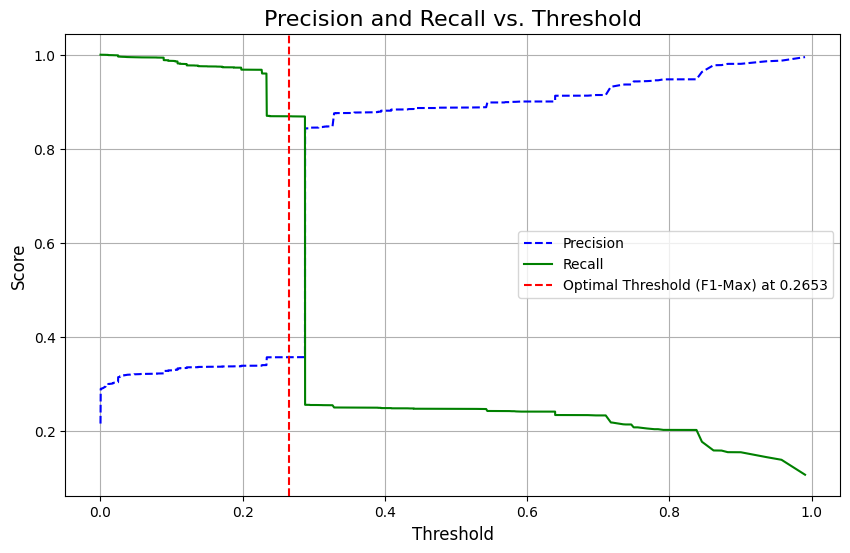

In [48]:
import matplotlib.pyplot as plt

# Find the threshold that maximizes the F1-Score (a balance between precision and recall)
f1_scores = 2 * (precision * recall) / (precision + recall)
# Get the best threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold that maximizes F1-Score: {optimal_threshold:.4f}")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot Precision and Recall lines
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')

# Plot the optimal threshold line
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold (F1-Max) at {optimal_threshold:.4f}')

plt.title('Precision and Recall vs. Threshold', fontsize=16)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [50]:
# set the threshold to the optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# evaluate the classification report on test with optimal threshold
print(classification_report(y_test, y_pred_optimal))

# confusion matrix with optimal threshold
print("Confusion Matrix with Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_optimal))

              precision    recall  f1-score   support

       False       0.94      0.57      0.71   1671246
        True       0.36      0.87      0.51    458669

    accuracy                           0.63   2129915
   macro avg       0.65      0.72      0.61   2129915
weighted avg       0.81      0.63      0.67   2129915

Confusion Matrix with Optimal Threshold:
[[952006 719240]
 [ 60061 398608]]


In [12]:
# from tqdm import tqdm

# def check_github_user_exists(login):
# 	url = f"https://github.com/{login}"
# 	response = requests.get(url)
# 	return response.status_code == 200

# valid_count = 0
# invalid_count = 0
# invalid_usernames = []

# for username in tqdm(df_notsus['login'], desc="Checking users"):
# 	is_valid = check_github_user_exists(username)
# 	if is_valid:
# 		valid_count += 1
# 	else:
# 		invalid_count += 1
# 		invalid_usernames.append(username)

# print(f"Valid users: {valid_count}, Invalid users: {invalid_count}")
# print("Invalid usernames:", invalid_usernames)

In [ ]:
# TO DO:
# 1. Remove invalid usernames from df_notsus
# 2. commits/public_repos
# 3. profile_completeness
# 4. star_to_commit_ratio

### GITPOL MODEL V2 - LSTM

In [55]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl (38 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached grpcio-1.73.1-cp310-cp310-win_amd64.whl (4.3 MB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl (2.9 MB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl (209 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl (434 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl (135 

You should consider upgrading via the 'd:\.STUDY\Cawu5\RM\CODE\gitpol_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

y_train_lstm = y_train.astype(int).values
y_test_lstm = y_test.astype(int).values

model_lstm = Sequential([
	LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=False),
	Dropout(0.3),
	Dense(32, activation='relu'),
	Dropout(0.2),
	Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(
	X_train_lstm, y_train_lstm,
	validation_data=(X_test_lstm, y_test_lstm),
	epochs=3,
	batch_size=1024
)

d:\.STUDY\Cawu5\RM\CODE\gitpol_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
8320/8320 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.8218 - loss: 0.4054 - val_accuracy: 0.8295 - val_loss: 0.3738
Epoch 2/3
8320/8320 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.8294 - loss: 0.3756 - val_accuracy: 0.8299 - val_loss: 0.3720
Epoch 3/3
8320/8320 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.8303 - loss: 0.3732 - val_accuracy: 0.8301 - val_loss: 0.3718


In [7]:
# evaluate classification report on train

y_train_pred = (model_lstm.predict(X_train_lstm) > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_train_lstm, y_train_pred))

266240/266240 ━━━━━━━━━━━━━━━━━━━━ 472s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.99      0.90   6684985
           1       0.88      0.24      0.38   1834674

    accuracy                           0.83   8519659
   macro avg       0.85      0.62      0.64   8519659
weighted avg       0.84      0.83      0.79   8519659



In [8]:
# evaluate classification report on test
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_lstm, y_pred_lstm))

66560/66560 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.99      0.90   1671246
           1       0.88      0.24      0.38    458669

    accuracy                           0.83   2129915
   macro avg       0.85      0.62      0.64   2129915
weighted avg       0.84      0.83      0.79   2129915



In [9]:
# confusion matrix

from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_lstm, y_pred_lstm))

# false positives and false negatives
print("False Positives:", confusion_matrix(y_test_lstm, y_pred_lstm)[1][0])
print("False Negatives:", confusion_matrix(y_test_lstm, y_pred_lstm)[0][1])

Confusion Matrix:
[[1656198   15048]
 [ 346852  111817]]
False Positives: 346852
False Negatives: 15048


In [13]:
# save the lstm model

import joblib

joblib.dump(model_lstm, 'model/gitpol_model_v2_lstm_minimum_false_flag.pkl')

['model/gitpol_model_v2_lstm_minimum_false_flag.pkl']

### GITPOL MODEL V3 - RANDOM UNDER SAMPING

In [5]:
# train an XGBoost model
import xgboost as xgb

model = xgb.XGBClassifier(
	n_estimators=100,
	max_depth=6,
	learning_rate=0.1,
	random_state=42,
	eval_metric='logloss',
)

model.fit(X_train_res, y_train_res)

model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [6]:
# evaluate the classification report on train

from sklearn.metrics import classification_report

y_pred = model.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.48      0.64   1834674
        True       0.65      0.97      0.78   1834674

    accuracy                           0.72   3669348
   macro avg       0.79      0.72      0.71   3669348
weighted avg       0.79      0.72      0.71   3669348



In [7]:
# evaluate the classification report on test

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.48      0.65   1671246
        True       0.34      0.97      0.50    458669

    accuracy                           0.59   2129915
   macro avg       0.66      0.72      0.57   2129915
weighted avg       0.84      0.59      0.61   2129915



In [9]:
# save the xgboost with random undersampling model

import joblib

joblib.dump(model, 'model/gitpol_model_v3_xgboost_random_undersampling.pkl')

['model/gitpol_model_v3_xgboost_random_undersampling.pkl']

In [10]:
# save the undersampled data to a CSV file
df_resampled = pd.concat([X_train_res, y_train_res], axis=1)

df_resampled.to_csv('data_undersampled.csv', index=False)

In [36]:
# save the test data to a CSV file
df_test = pd.concat([X_test, y_test], axis=1)
df_test.to_csv('data_test.csv', index=False)

### GITPOL MODEL V4 - EXTRA LAYER AFTER MODEL V3

In [49]:
# load combined data
import pandas as pd

df_combined = pd.read_csv('data_combined.csv')

# add new column for profile completeness
df_combined['profile_completeness'] = df_combined[['company', 'hirable', 'location', 'bio', 'blog']].sum(axis=1)

# add new column for commit_to_public_repo
df_combined['commit_to_public_repo'] = df_combined['commits'] / (df_combined['public_repos'] + 1)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649574 entries, 0 to 10649573
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   hirable                int64  
 1   public_repos           int64  
 2   is_suspicious          bool   
 3   id                     int64  
 4   blog                   int64  
 5   followers              int64  
 6   location               int64  
 7   type                   int64  
 8   bio                    int64  
 9   commits                float64
 10  company                int64  
 11  public_gists           int64  
 12  following              int64  
 13  login                  object 
 14  profile_completeness   int64  
 15  commit_to_public_repo  float64
dtypes: bool(1), float64(2), int64(12), object(1)
memory usage: 1.2+ GB


#### EDA FOR VALIDATION RULES

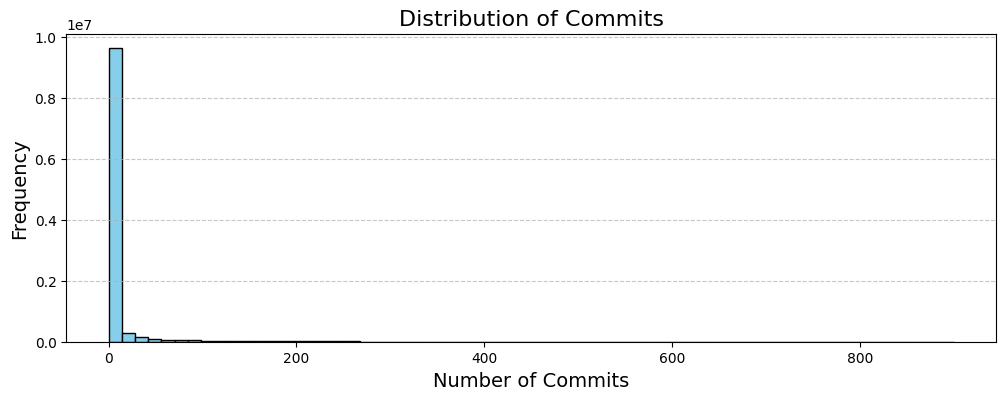

In [17]:
# plot the distribution of commits

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.hist(df_combined['commits'], bins=64, color='skyblue', edgecolor='black')
plt.title('Distribution of Commits', fontsize=16)
plt.xlabel('Number of Commits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
# describe the commits column
df_combined['commits'].describe()

count    1.064957e+07
mean     1.113685e+01
std      5.463350e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.000000e+02
Name: commits, dtype: float64

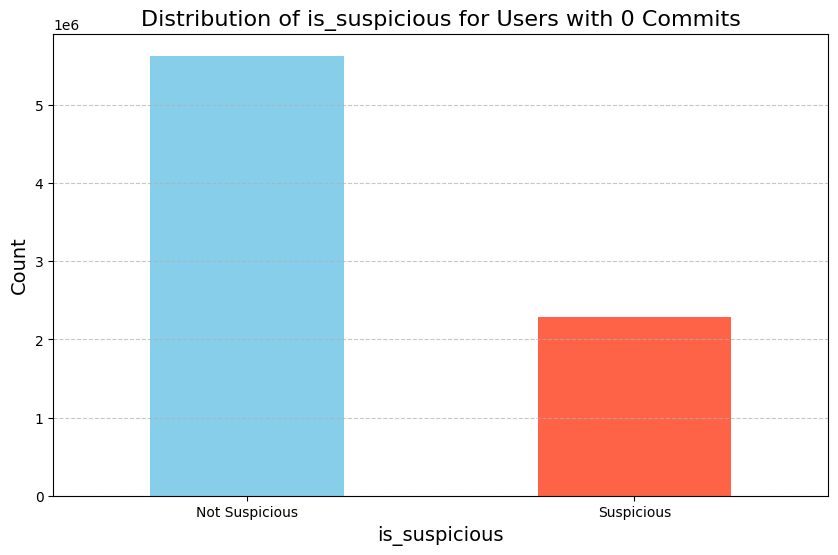

In [22]:
# plot the distribution of is_suspicious with commits 0

df_combined_zero_commits = df_combined[df_combined['commits'] == 0]
plt.figure(figsize=(10, 6))
df_combined_zero_commits['is_suspicious'].value_counts().plot(kind='bar', color=['skyblue', 'tomato'])
plt.title('Distribution of is_suspicious for Users with 0 Commits', fontsize=16)
plt.xlabel('is_suspicious', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Suspicious', 'Suspicious'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

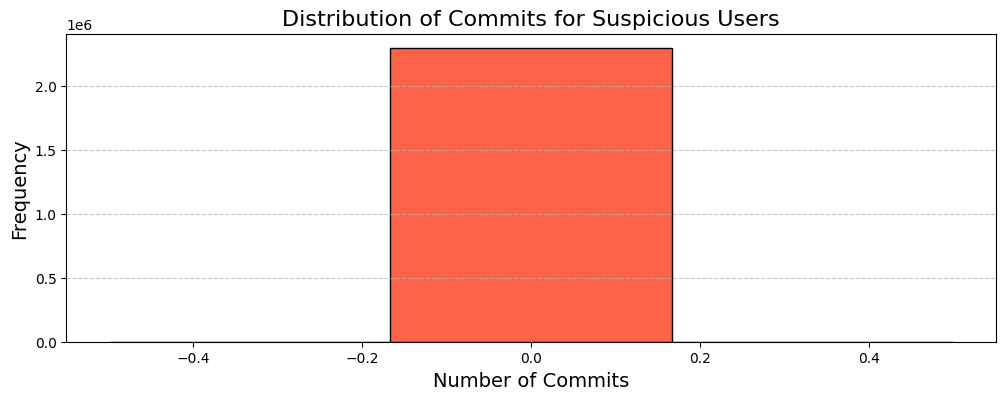

In [51]:
# plot the distribution of commits of suspicious users
df_suspicious = df_combined[df_combined['is_suspicious'] == 1]
plt.figure(figsize=(12, 4))
plt.hist(df_suspicious['commits'], bins=3, color='tomato', edgecolor='black')
plt.title('Distribution of Commits for Suspicious Users', fontsize=16)
plt.xlabel('Number of Commits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
# describe the commits column of suspicious users
df_suspicious['commits'].describe()

count    2293343.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: commits, dtype: float64

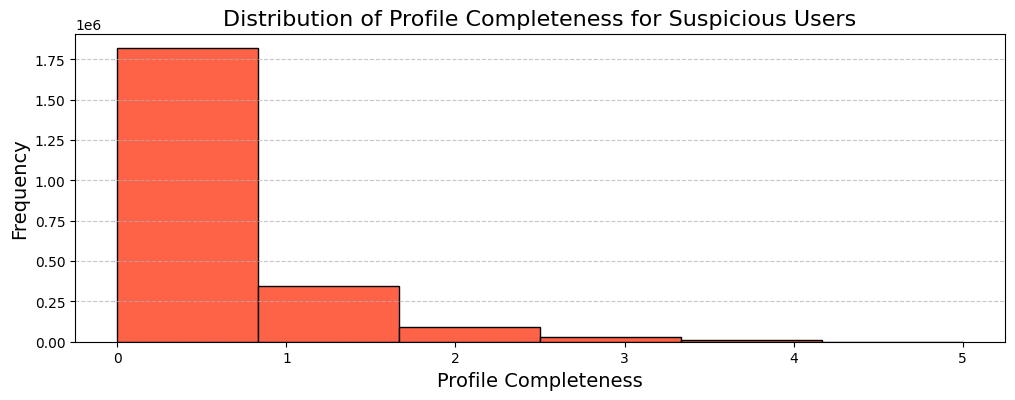

In [53]:
# plot the distribution of profile_completeness for suspicious users
plt.figure(figsize=(12, 4))
plt.hist(df_suspicious['profile_completeness'], bins=6, color='tomato', edgecolor='black')
plt.title('Distribution of Profile Completeness for Suspicious Users', fontsize=16)
plt.xlabel('Profile Completeness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

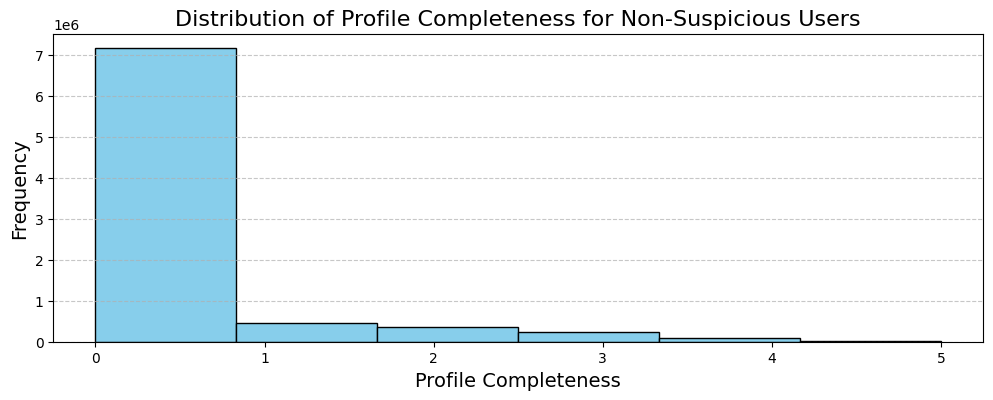

In [54]:
# plot the distribution of profile_completeness for non suspicious users
df_non_suspicious = df_combined[df_combined['is_suspicious'] == 0]
plt.figure(figsize=(12, 4))
plt.hist(df_non_suspicious['profile_completeness'], bins=6, color='skyblue', edgecolor='black')
plt.title('Distribution of Profile Completeness for Non-Suspicious Users', fontsize=16)
plt.xlabel('Profile Completeness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

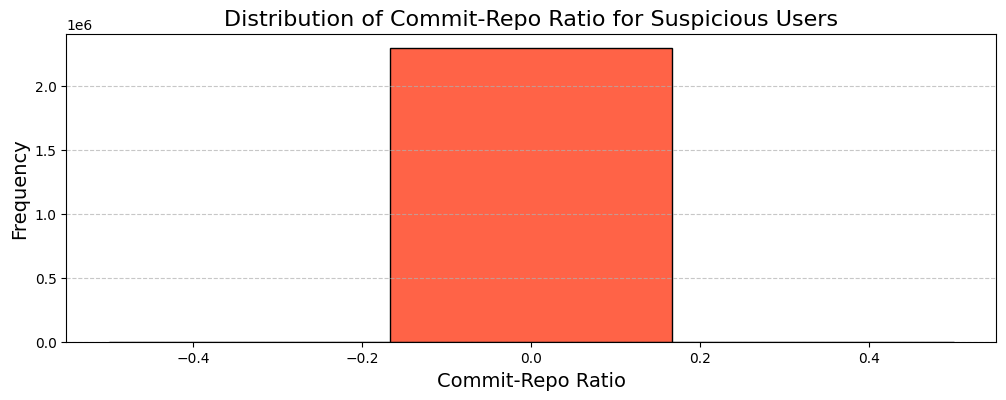

In [56]:
# plot the distribution of commit_to_public_repo for suspicious users
plt.figure(figsize=(12, 4))
plt.hist(df_suspicious['commit_to_public_repo'], bins=3, color='tomato', edgecolor='black')
plt.title('Distribution of Commit-Repo Ratio for Suspicious Users', fontsize=16)
plt.xlabel('Commit-Repo Ratio', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

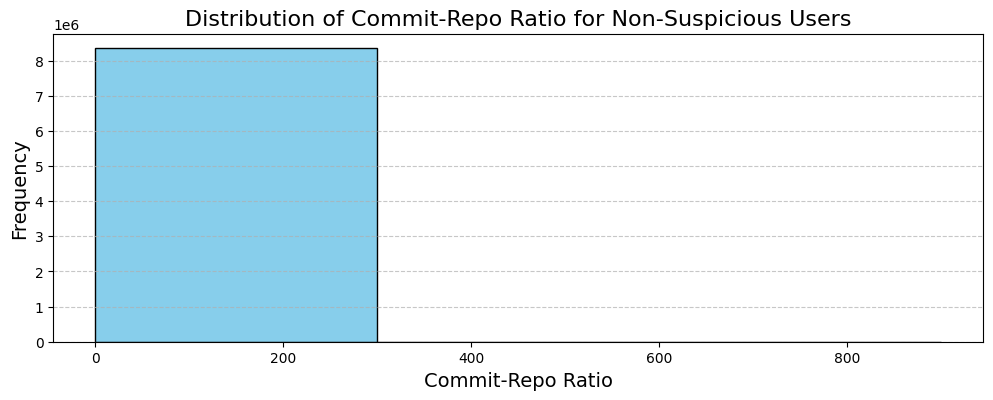

In [57]:
# plot the distribution of commit_to_public_repo for non suspicious users
plt.figure(figsize=(12, 4))
plt.hist(df_non_suspicious['commit_to_public_repo'], bins=3, color='skyblue', edgecolor='black')
plt.title('Distribution of Commit-Repo Ratio for Non-Suspicious Users', fontsize=16)
plt.xlabel('Commit-Repo Ratio', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [58]:
df_non_suspicious['commit_to_public_repo'].describe()

count    8.356231e+06
mean     2.417788e+00
std      1.392717e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.666667e-01
max      9.000000e+02
Name: commit_to_public_repo, dtype: float64

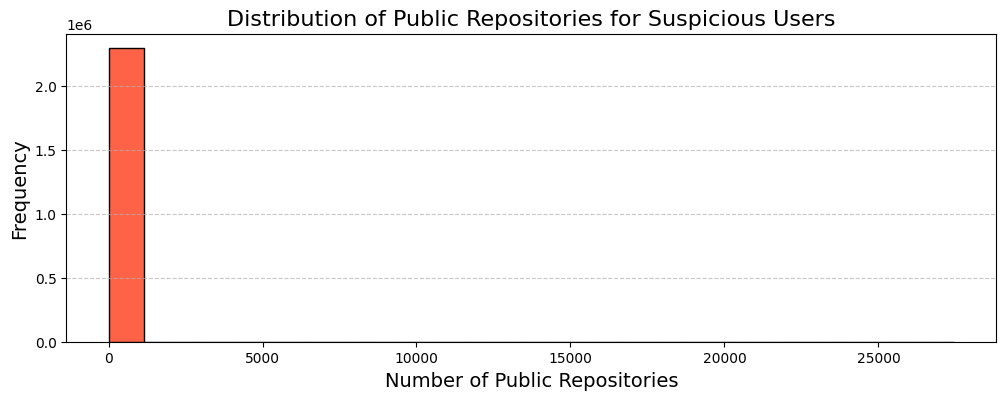

In [68]:
# plot the distribution of public repos of suspicious users

plt.figure(figsize=(12, 4))
plt.hist(df_suspicious['public_repos'], bins=24, color='tomato', edgecolor='black')
plt.title('Distribution of Public Repositories for Suspicious Users', fontsize=16)
plt.xlabel('Number of Public Repositories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [62]:
df_suspicious['public_repos'].describe()

count    2.293343e+06
mean     3.860988e-01
std      3.083147e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.745500e+04
Name: public_repos, dtype: float64

In [70]:
# print unique values in public_repos
print("Unique values in public_repos for suspicious users:")
print(df_suspicious['public_repos'].unique())

Unique values in public_repos for suspicious users:
[    3     1     0     2    17     4     5   254    65   238    37     8
    15     7    20    63    12     6   132    34    19    23    21   248
     9    31    36    16    13    11    26    57    29    28   272    10
    14    32    83   261    35    30   206    22    44    24    79    45
    86   141   256    42   242   223    80    38   404   185    27  2280
    61    87    49   245    40    51    18   388    71    50    53    47
   243   247   127  2276    55    25   217   351   407   239   237   371
    48    75   257   436    52   386   718   121   347   439   252    41
    43   416    46  1326   111   167   262    76   273   365   244    72
   278   283    66    39   147   387   213    62   356   292   220  1314
    82  1398   259   260    88    77    60    59   980    78   199   225
    68   264    97    90    33   233    56   295   250   157   249   115
   352   108   463    54   152    84    73   148   298   441   406   400

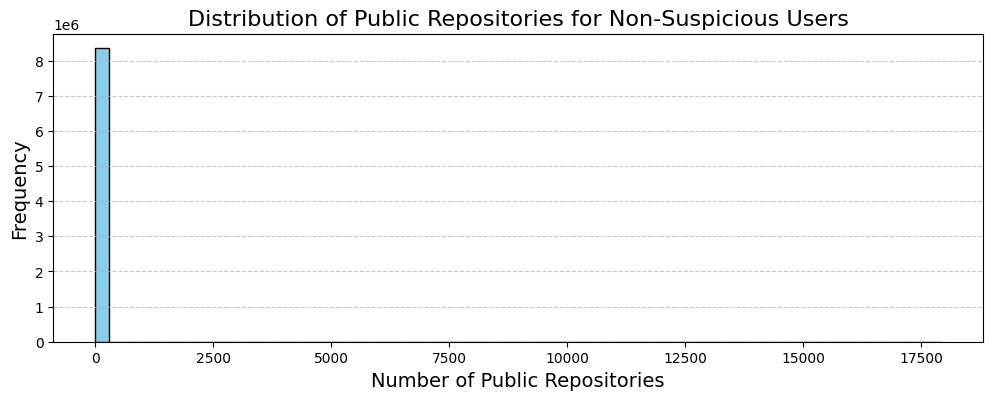

In [69]:
# plot the distribution of public repos of non suspicious users

plt.figure(figsize=(12, 4))
plt.hist(df_non_suspicious['public_repos'], bins=64, color='skyblue', edgecolor='black')
plt.title('Distribution of Public Repositories for Non-Suspicious Users', fontsize=16)
plt.xlabel('Number of Public Repositories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
df_non_suspicious['public_repos'].describe()

count    8.356231e+06
mean     2.513006e+00
std      1.957590e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.791600e+04
Name: public_repos, dtype: float64

#### IMPLEMENT THE CODE

In [37]:
# load data_undersampled
df_undersampled = pd.read_csv('data_undersampled.csv')

X_train_res = df_undersampled.drop(columns=['is_suspicious'])
y_train_res = df_undersampled['is_suspicious']

df_test = pd.read_csv('data_test.csv')

X_test = df_test.drop(columns=['is_suspicious'])
y_test = df_test['is_suspicious']

In [42]:
# train an XGBoost model
import xgboost as xgb

model = xgb.XGBClassifier(
	n_estimators=100,
	max_depth=6,
	learning_rate=0.1,
	random_state=42,
	eval_metric='logloss',
)

model.fit(X_train_res, y_train_res)

model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_model = y_proba >= 0.5

In [45]:
from dotenv import load_dotenv
import os
load_dotenv()

def get_starred_repo_count(username, token=os.getenv("GITHUB_TOKEN")):
    import requests

    url = "https://api.github.com/graphql"
    headers = {
        "Authorization": f"Bearer {token}"
    }

    query = """
    query ($login: String!) {
      user(login: $login) {
        starredRepositories {
          totalCount
        }
      }
    }
    """

    variables = {
        "login": username
    }

    response = requests.post(url, json={"query": query, "variables": variables}, headers=headers)

    if response.status_code != 200:
        print(f"HTTP error for {username}: {response.status_code}")
        return None

    result = response.json()

    # Check for GraphQL-level errors
    if "errors" in result:
        print(f"GraphQL error for {username}: {result['errors'][0].get('message')}")
        return None

    user_data = result.get("data", {}).get("user")

    if user_data is None:
        print(f"No user data for {username}")
        return None

    return user_data["starredRepositories"]["totalCount"]


In [ ]:
def postprocess_prediction(x_row, model_pred):
	
	x_row['star_count'] = get_starred_repo_count(x_row['login'])

	if model_pred and x_row['transaction_amount'] < 10:
		return False
	return model_pred

y_pred_final = [
	postprocess_prediction(row, pred)
	for row, pred in zip(X_test.to_dict(orient='records'), y_pred_model)
]

In [38]:
# evaluate the classification report on train

from sklearn.metrics import classification_report

y_pred = model.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.48      0.64   1834674
        True       0.65      0.97      0.78   1834674

    accuracy                           0.72   3669348
   macro avg       0.79      0.72      0.71   3669348
weighted avg       0.79      0.72      0.71   3669348



In [39]:
# evaluate the classification report on test

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.48      0.65   1671246
        True       0.34      0.97      0.50    458669

    accuracy                           0.59   2129915
   macro avg       0.66      0.72      0.57   2129915
weighted avg       0.84      0.59      0.61   2129915

